# Random Forest Analysis of Balanced Datasets

Some typical imports and useful setup for the dataset:

In [1]:
TEXT_FIELD = 'title'
TEXT_ENCODING = 'one-hot'
assert TEXT_FIELD in ('abstract', 'title'), 'TEXT_FIELD must be one of "title" or "abstract".'
assert TEXT_ENCODING in ('one-hot', 'tokenized'), 'TEXT_ENCODING must be one of "one-hot" or "tokenized".'
# The above choices determine the relevant sequence length of the data.
if TEXT_ENCODING == 'one-hot':
    SEQ_LEN = 128 if TEXT_FIELD == 'title' else 2048
else:
    SEQ_LEN = int(1.5 * 16) if TEXT_FIELD == 'title' else int(1.5 * 256)

In [2]:
%%capture import_capture --no-stder
# Jupyter magic methods
# For auto-reloading when external modules are changed
%load_ext autoreload
%autoreload 2
# For showing plots inline
%matplotlib inline

# pip installs needed in Colab for arxiv_vixra_models
!pip install wandb
# Update sklearn
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option(u'float_format', '{:f}'.format)

import wandb

Fix a global random state to be used for all seeds:

In [3]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [4]:
# Give the notebook access to the rest of your google drive files.
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# Enter the relevant foldername
FOLDERNAME = '/content/drive/My Drive/ML/arxiv_vixra'
assert FOLDERNAME is not None, "[!] Enter the foldername."
# For importing .py modules stored in FOLDERNAME or a subdirectory:
import sys
sys.path.append(FOLDERNAME)

Mounted at /content/drive


In [5]:
train_data_file_name = 'balanced_filtered_normalized_data_train.feather'
val_data_file_name = 'balanced_filtered_normalized_data_validation.feather'
SUBDIR = '/data/data_splits/'
train_data_path = FOLDERNAME + SUBDIR + train_data_file_name
val_data_path = FOLDERNAME + SUBDIR + val_data_file_name
if TEXT_ENCODING == 'one-hot':
    tokens_file_name = 'normalized_char_set.feather'
elif TEXT_FIELD == 'abstract':
    tokens_file_name = 'balanced_abstract_normalized_vocab.feather'
else:
    tokens_file_name = 'balanced_title_normalized_vocab.feather'
tokens_path = FOLDERNAME + SUBDIR + tokens_file_name
!cp '{train_data_path}' .
!cp '{val_data_path}' .
!cp '{tokens_path}' .

In [6]:
train_data_df = pd.read_feather(train_data_file_name)
val_data_df = pd.read_feather(val_data_file_name)
tokens_df = pd.read_feather(tokens_file_name)

Use notebook name as `wandb` `project` string. Remove the file extension and any "Copy of" or "Kopie van" text which arises from copying notebooks and running in parallel.

In [7]:
from requests import get
PROJECT = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
PROJECT = PROJECT.replace('.ipynb', '').replace('Kopie%20van%20', '').replace('Copy%20of%20', '')
print(PROJECT)

balanced_title_rf


# Feature engineering

Focus only on the titles.

In [8]:
train_data_title_source_df = train_data_df[['title', 'source']]
train_data_title_source_df.head()

,title,source
0,reits : reflective surface for intelligent tra...,arxiv
1,mirror images and division by zero calculus,vixra
2,electromagnetic waves in an expanding 5d universe,vixra
3,atomic - scale erector,vixra
4,temperature dependence of microwave and thz di...,arxiv


Add in a random column as a sanity check, inspired by [this post on RF feature importances](https://explained.ai/rf-importance/index.html).

In [9]:
train_data_title_source_df['random'] = pd.Series(np.random.random(len(train_data_title_source_df)))

Let us first add various counting stats to the `DataFrame`

In [10]:
train_data_title_source_df['char_len'] = train_data_title_source_df['title'].str.len()
train_data_title_source_df['numerical_percent'] = train_data_title_source_df['title'].apply(lambda x: sum(ch.isdigit() for ch in x)) / train_data_title_source_df['char_len']
train_data_title_source_df['longest_word'] = train_data_title_source_df['title'].apply(lambda x: np.max([len(word) for word in x.split()]))

Add columns for whether the starting or ending character is non-alphanumeric and not a blank space as well as counts/frequencies of these chars.  Some characters need escaping and we need to avoid performing `counts` with `|`, `.`, `^`, and `$` because `pd`'s `str.count` method takes in `regex` expressions, unlike `str.endswith` or `str.startswith`. We handle these edge cases by hand (annoyingly).


In [11]:
for ch in tokens_df.char:
    if not ch.isalnum() and ch not in  (' ', '|', '.', '$', '^'):
        train_data_title_source_df[f'ends_with_{ch}'] = train_data_title_source_df.title.str.endswith(ch)
        train_data_title_source_df[f'starts_with_{ch}'] = train_data_title_source_df.title.str.startswith(ch)
        try:
            train_data_title_source_df[f'{ch}_percent'] = train_data_title_source_df.title.str.count(ch) / train_data_title_source_df.title.str.len()
        except Exception as e:
            print(e)
            print(f'Failed on character {ch}')

missing ), unterminated subpattern at position 0
Failed on character (
unbalanced parenthesis at position 0
Failed on character )
nothing to repeat at position 0
Failed on character *
nothing to repeat at position 0
Failed on character +
nothing to repeat at position 0
Failed on character ?
unterminated character set at position 0
Failed on character [
bad escape (end of pattern) at position 0
Failed on character \


Handling remaining cases:

In [12]:
for ch in ('\(', '\)', '\*', '\+', '\?', '\[', '\|', '\\\\', '\.', '\$', '\^'):
    try:
        train_data_title_source_df[f'{ch[-1]}_percent'] = train_data_title_source_df.title.str.count(ch) / train_data_title_source_df.title.str.len()
    except Exception as e:
        print(e)
        print(f'failed on {ch}')

Some of the engineered features are trivial (all of which could be reasonably expected):

In [13]:
trivial_features = [column_name for column_name, column_values  in train_data_title_source_df.drop('source', axis=1).iteritems() if not column_values.any()]
trivial_features

['starts_with_!',
 'starts_with_%',
 'ends_with_&',
 'starts_with_&',
 'ends_with_(',
 'starts_with_)',
 'starts_with_+',
 'starts_with_,',
 'starts_with_/',
 'starts_with_:',
 'ends_with_;',
 'starts_with_;',
 'ends_with_<',
 'starts_with_=',
 'starts_with_>',
 'starts_with_?',
 'ends_with_@',
 'starts_with_@',
 'ends_with_[',
 'ends_with_\\',
 'starts_with_]',
 'ends_with__',
 'starts_with__',
 'ends_with_`',
 'ends_with_{',
 'starts_with_}',
 'ends_with_~',
 'starts_with_~']

Remove them:

In [14]:
train_data_title_source_df = train_data_title_source_df.drop(trivial_features, axis=1)

Let's compute the average rank of the words used in the abstracts and titles

In [15]:
vocab_file_name = 'balanced_title_normalized_vocab.feather'
vocab_path = FOLDERNAME + SUBDIR + vocab_file_name
!cp '{vocab_path}' .
vocab_df = pd.read_feather(vocab_file_name)

The vocab `df` is ordered by rank of how common the words are. Very basic/naive preprocessing was applied such all forms of punctutation were also included as words.

In [16]:
vocab_df

,word,count
0,of,16881
1,-,15158
2,the,13569
3,and,9737
4,in,7861
...,...,...
23941,condensing,1
23942,anyone,1
23943,highlighting,1
23944,snippets,1


Create a small function to compute word mean word rank.

Create the word-rank dictionary first.

In [17]:
vocab_rank_word_dict = vocab_df['word'].to_dict()
vocab_word_rank_dict = {val: key for key, val in vocab_rank_word_dict.items()}

In [18]:
def mean_word_rank(text, word_rank_dict=vocab_word_rank_dict):
    highest_rank = len(word_rank_dict) + 1
    words = text.split()
    ranks = np.array([word_rank_dict.get(w, highest_rank) for w in words])
    return ranks.mean()

In [19]:
train_data_title_source_df['mean_word_rank'] = train_data_title_source_df.title.apply(mean_word_rank)

In [20]:
train_data_title_source_df

,title,source,random,char_len,numerical_percent,longest_word,ends_with_!,!_percent,"ends_with_""","starts_with_""","""_percent",ends_with_#,starts_with_#,#_percent,ends_with_%,%_percent,&_percent,ends_with_',starts_with_','_percent,starts_with_(,ends_with_),ends_with_*,starts_with_*,ends_with_+,"ends_with_,",",_percent",ends_with_-,starts_with_-,-_percent,ends_with_/,/_percent,ends_with_:,:_percent,;_percent,starts_with_<,<_percent,ends_with_=,=_percent,ends_with_>,>_percent,ends_with_?,@_percent,starts_with_[,starts_with_\,ends_with_],]_percent,__percent,starts_with_`,`_percent,starts_with_{,{_percent,ends_with_},}_percent,~_percent,(_percent,)_percent,*_percent,+_percent,?_percent,[_percent,|_percent,\_percent,._percent,$_percent,^_percent,mean_word_rank
0,reits : reflective surface for intelligent tra...,arxiv,0.374540,65,0.000000,14,False,0.000000,False,False,0.000000,False,False,0.000000,False,0.000000,0.000000,False,False,0.000000,False,False,False,False,False,False,0.000000,False,False,0.000000,False,0.000000,False,0.015385,0.000000,False,0.000000,False,0.000000,False,0.000000,False,0.000000,False,False,False,0.000000,0.000000,False,0.000000,False,0.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2773.250000
1,mirror images and division by zero calculus,vixra,0.950714,43,0.000000,8,False,0.000000,False,False,0.000000,False,False,0.000000,False,0.000000,0.000000,False,False,0.000000,False,False,False,False,False,False,0.000000,False,False,0.000000,False,0.000000,False,0.000000,0.000000,False,0.000000,False,0.000000,False,0.000000,False,0.000000,False,False,False,0.000000,0.000000,False,0.000000,False,0.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,459.285714
2,electromagnetic waves in an expanding 5d universe,vixra,0.731994,49,0.020408,15,False,0.000000,False,False,0.000000,False,False,0.000000,False,0.000000,0.000000,False,False,0.000000,False,False,False,False,False,False,0.000000,False,False,0.000000,False,0.000000,False,0.000000,0.000000,False,0.000000,False,0.000000,False,0.000000,False,0.000000,False,False,False,0.000000,0.000000,False,0.000000,False,0.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,739.571429
3,atomic - scale erector,vixra,0.598658,22,0.000000,7,False,0.000000,False,False,0.000000,False,False,0.000000,False,0.000000,0.000000,False,False,0.000000,False,False,False,False,False,False,0.000000,False,False,0.045455,False,0.000000,False,0.000000,0.000000,False,0.000000,False,0.000000,False,0.000000,False,0.000000,False,False,False,0.000000,0.000000,False,0.000000,False,0.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3031.250000
4,temperature dependence of microwave and thz di...,arxiv,0.156019,98,0.051020,11,False,0.000000,False,False,0.000000,False,False,0.000000,False,0.000000,0.000000,False,False,0.000000,False,True,False,False,False,False,0.000000,False,False,0.010204,False,0.000000,False,0.000000,0.000000,False,0.000000,False,0.010204,False,0.000000,False,0.000000,False,False,False,0.000000,0.000000,False,0.000000,False,0.000000,False,0.000000,0.000000,0.010204,0.010204,0.000000,0.020408,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1677.523810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35137,"stimulated topological condensation of "" vapou...",vixra,0.310009,116,0.000000,12,False,0.000000,False,False,0.017241,False,False,0.000000,False,0.000000,0.000000,False,False,0.000000,False,False,False,False,False,False,0.000000,False,False,

Perform the same computation on common words which appear more than 5 times and which are longer than 4 chars, say.

# Validation Set Feature Engineering

Performing all of the same steps on the validation set. Create a helper function which acts on a `DataFrame` with a `title` and `source` column.

In [21]:
def feature_engineering_helper(df, trivial_features=None):
    titles_source_df = df[['title', 'source']]
    titles_source_df['random'] = pd.Series(np.random.randn(len(titles_source_df)))
    # Avoid counting blank space.
    titles_source_df['char_len'] = titles_source_df['title'].str.len()
    titles_source_df['numerical_percent'] = titles_source_df['title'].apply(lambda x: sum(ch.isdigit() for ch in x)) / titles_source_df['char_len']
    titles_source_df['longest_word'] = titles_source_df['title'].apply(lambda x: np.max([len(word) for word in x.split()]))
    for ch in tokens_df.char:
        if not ch.isalnum() and ch not in  (' ', '|', '.', '$', '^'):
            titles_source_df[f'ends_with_{ch}'] = titles_source_df.title.str.endswith(ch)
            titles_source_df[f'starts_with_{ch}'] = titles_source_df.title.str.startswith(ch)
            try:
                titles_source_df[f'{ch}_percent'] = titles_source_df.title.str.count(ch) / titles_source_df.title.str.len()
            except Exception as e:
                print(e)
                print(f'Failed on character {ch}')
    for ch in ('\(', '\)', '\*', '\+', '\?', '\[', '\|', '\\\\', '\.', '\$', '^'):
        try:
            titles_source_df[f'{ch[-1]}_percent'] = titles_source_df.title.str.count(ch) / titles_source_df.title.str.len()
        except Exception as e:
            print(e)
            print(f'failed on {ch}')
    titles_source_df['mean_word_rank'] = titles_source_df.title.apply(mean_word_rank)
    if trivial_features is not None:
        titles_source_df = titles_source_df.drop(trivial_features, axis=1)
    return titles_source_df

In [22]:
val_data_title_source_df = feature_engineering_helper(val_data_df, trivial_features=trivial_features)

missing ), unterminated subpattern at position 0
Failed on character (
unbalanced parenthesis at position 0
Failed on character )
nothing to repeat at position 0
Failed on character *
nothing to repeat at position 0
Failed on character +
nothing to repeat at position 0
Failed on character ?
unterminated character set at position 0
Failed on character [
bad escape (end of pattern) at position 0
Failed on character \


# Visualize

View the corner plot for some selected categories

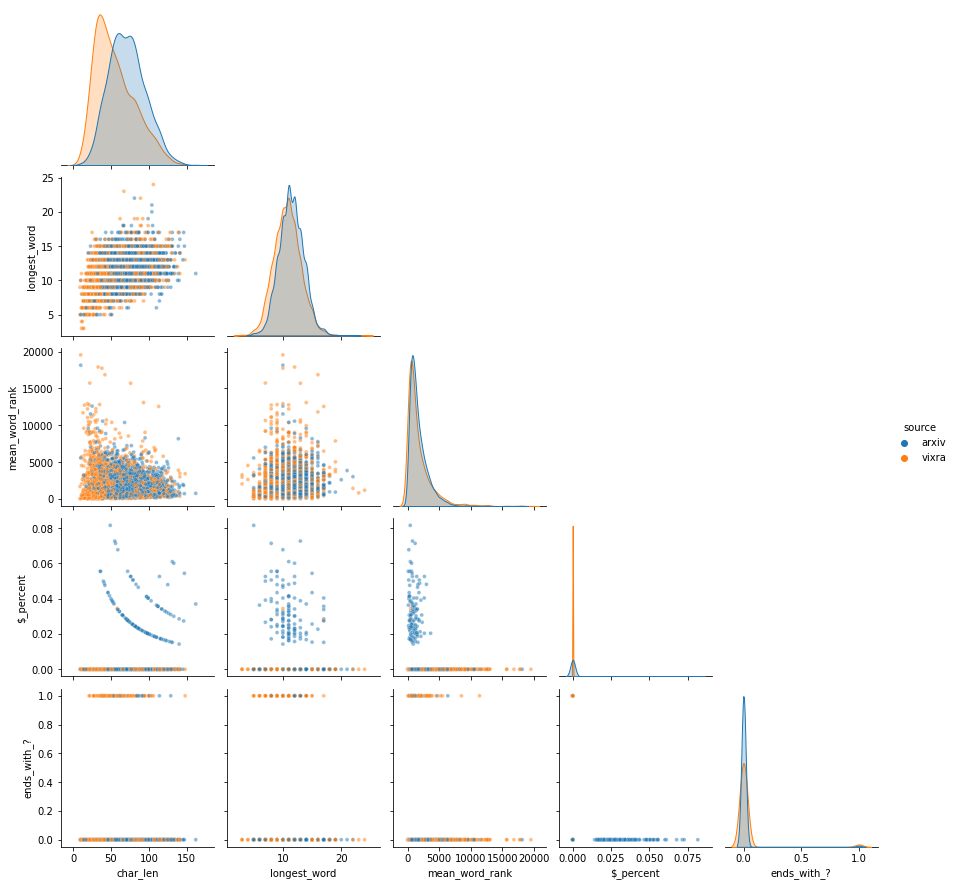

In [23]:
# Visualize a random sample.
plot_cats = ['char_len', 'longest_word', 'mean_word_rank', '$_percent','ends_with_?', 'source']
corner_plot_df = train_data_title_source_df.sample(5000, random_state=RANDOM_STATE)[plot_cats]
train_data_title_source_df_corner_plot = sns.pairplot(data=corner_plot_df,
             hue='source',
             plot_kws={'s': 15, 'alpha': .5},
             corner=True)
train_data_title_source_df_corner_plot.fig.savefig(FOLDERNAME + '/figures/rf_feature_engineering_corner_plot.png')

The `$_percent`-`char_len` subplot shows some strange correlations.  Let's zoom in on a portion of it:

,source,title,$_percent,char_len
648,arxiv,lattice coupled first order magnetoresistance transition in an a - type antiferromagnet : pr $ _ { 0 . 46 } $ sr $ _ { 0 . 54 } $ mno $ _ 3 $,0.042553,141
1227,arxiv,search for neutrinoless quadruple - $ \ beta $ decay of $ ^ { 150 } $ nd with the nemo - 3 detector,0.040404,99
1507,arxiv,on irreducible weight representations of a new deformation $ u _ { q } ( sl _ { 2 } ) $ of $ u ( sl _ { 2 } ) $,0.036036,111
1681,arxiv,extracting $ \ pi \ pi $ $ s $ - wave scattering lengths from cusp effect in heavy quarkonium dipion transitions,0.035714,112
1825,arxiv,"the teichm \ "" uller space of the standard action of $ sl ( 2 , z ) $ on $ t ^ 2 $ is trivial",0.043011,93
...,...,...,...,...
34091,arxiv,the h $ \ alpha $ line emission of the be star $ \ beta $ psc : the last 40 years,0.049383,81
34202,arxiv,comprehensive studies of $ \ upsilon $ inclusive production in $ z $ boson decay,0.050000,80
34657,arxiv,the magnetic moment of $ p _ { c } ( 4312 ) $ as a $ \ bar { d } \ sigma _ { c } $ molecular state,0.040816,98
34735,arxiv,fermi - surface topology of the heavy - fermion system ce $ _ { 2 } $ ptin $ _ { 8 } $,0.046512,86


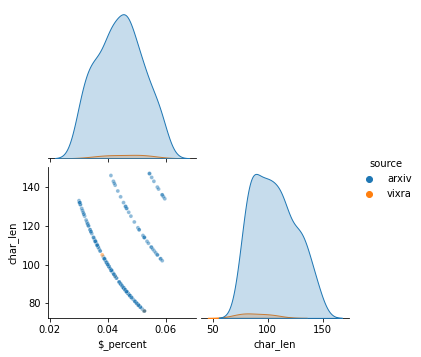

In [24]:
char_dollar_subset_mask = (train_data_title_source_df['$_percent'] > .03) & (train_data_title_source_df['$_percent'] < .06) & (train_data_title_source_df['char_len'] > 75) & (train_data_title_source_df['char_len'] < 150)
char_dollar_subset = train_data_title_source_df[char_dollar_subset_mask][['source', 'title', '$_percent', 'char_len']]
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 20):
    display(char_dollar_subset)
char_dollar_subset_corner_plot = sns.pairplot(data=char_dollar_subset,
             hue='source',
             plot_kws={'s': 15, 'alpha': .5},
             corner=True)
char_dollar_subset_corner_plot.fig.savefig(FOLDERNAME + '/figures/char_dollar_subset_corner_plot.png')

Though large-`$_percent` entires are almost sure to be `arxiv`, there aren't very many such examples as a fraction of the dataset:

In [25]:
# ~20 : 1 ratio of high-$_percent arxiv : vixra papers
high_dollar_maskk = (train_data_title_source_df['$_percent'] > .01)
print('High-$ arxiv papers count:', (train_data_title_source_df[high_dollar_maskk]['source'] == 'arxiv').sum())
print('High-$ vixra papers count:', (train_data_title_source_df[high_dollar_maskk]['source'] == 'vixra').sum())
# But, only a small fraction of all such have this many $:
print('Percent high-$ papers:', high_dollar_maskk.mean())

High-$ arxiv papers count: 858
High-$ vixra papers count: 40
Percent high-$ papers: 0.025553468783791475


Finally, inspect the correlation matrix.  This can be a good place to catch errors (as when I caught several issues due to `pd`'s `str.count` method taking `regex` strings, in contrast to its `str.endswith` and `str.startswith` methods).

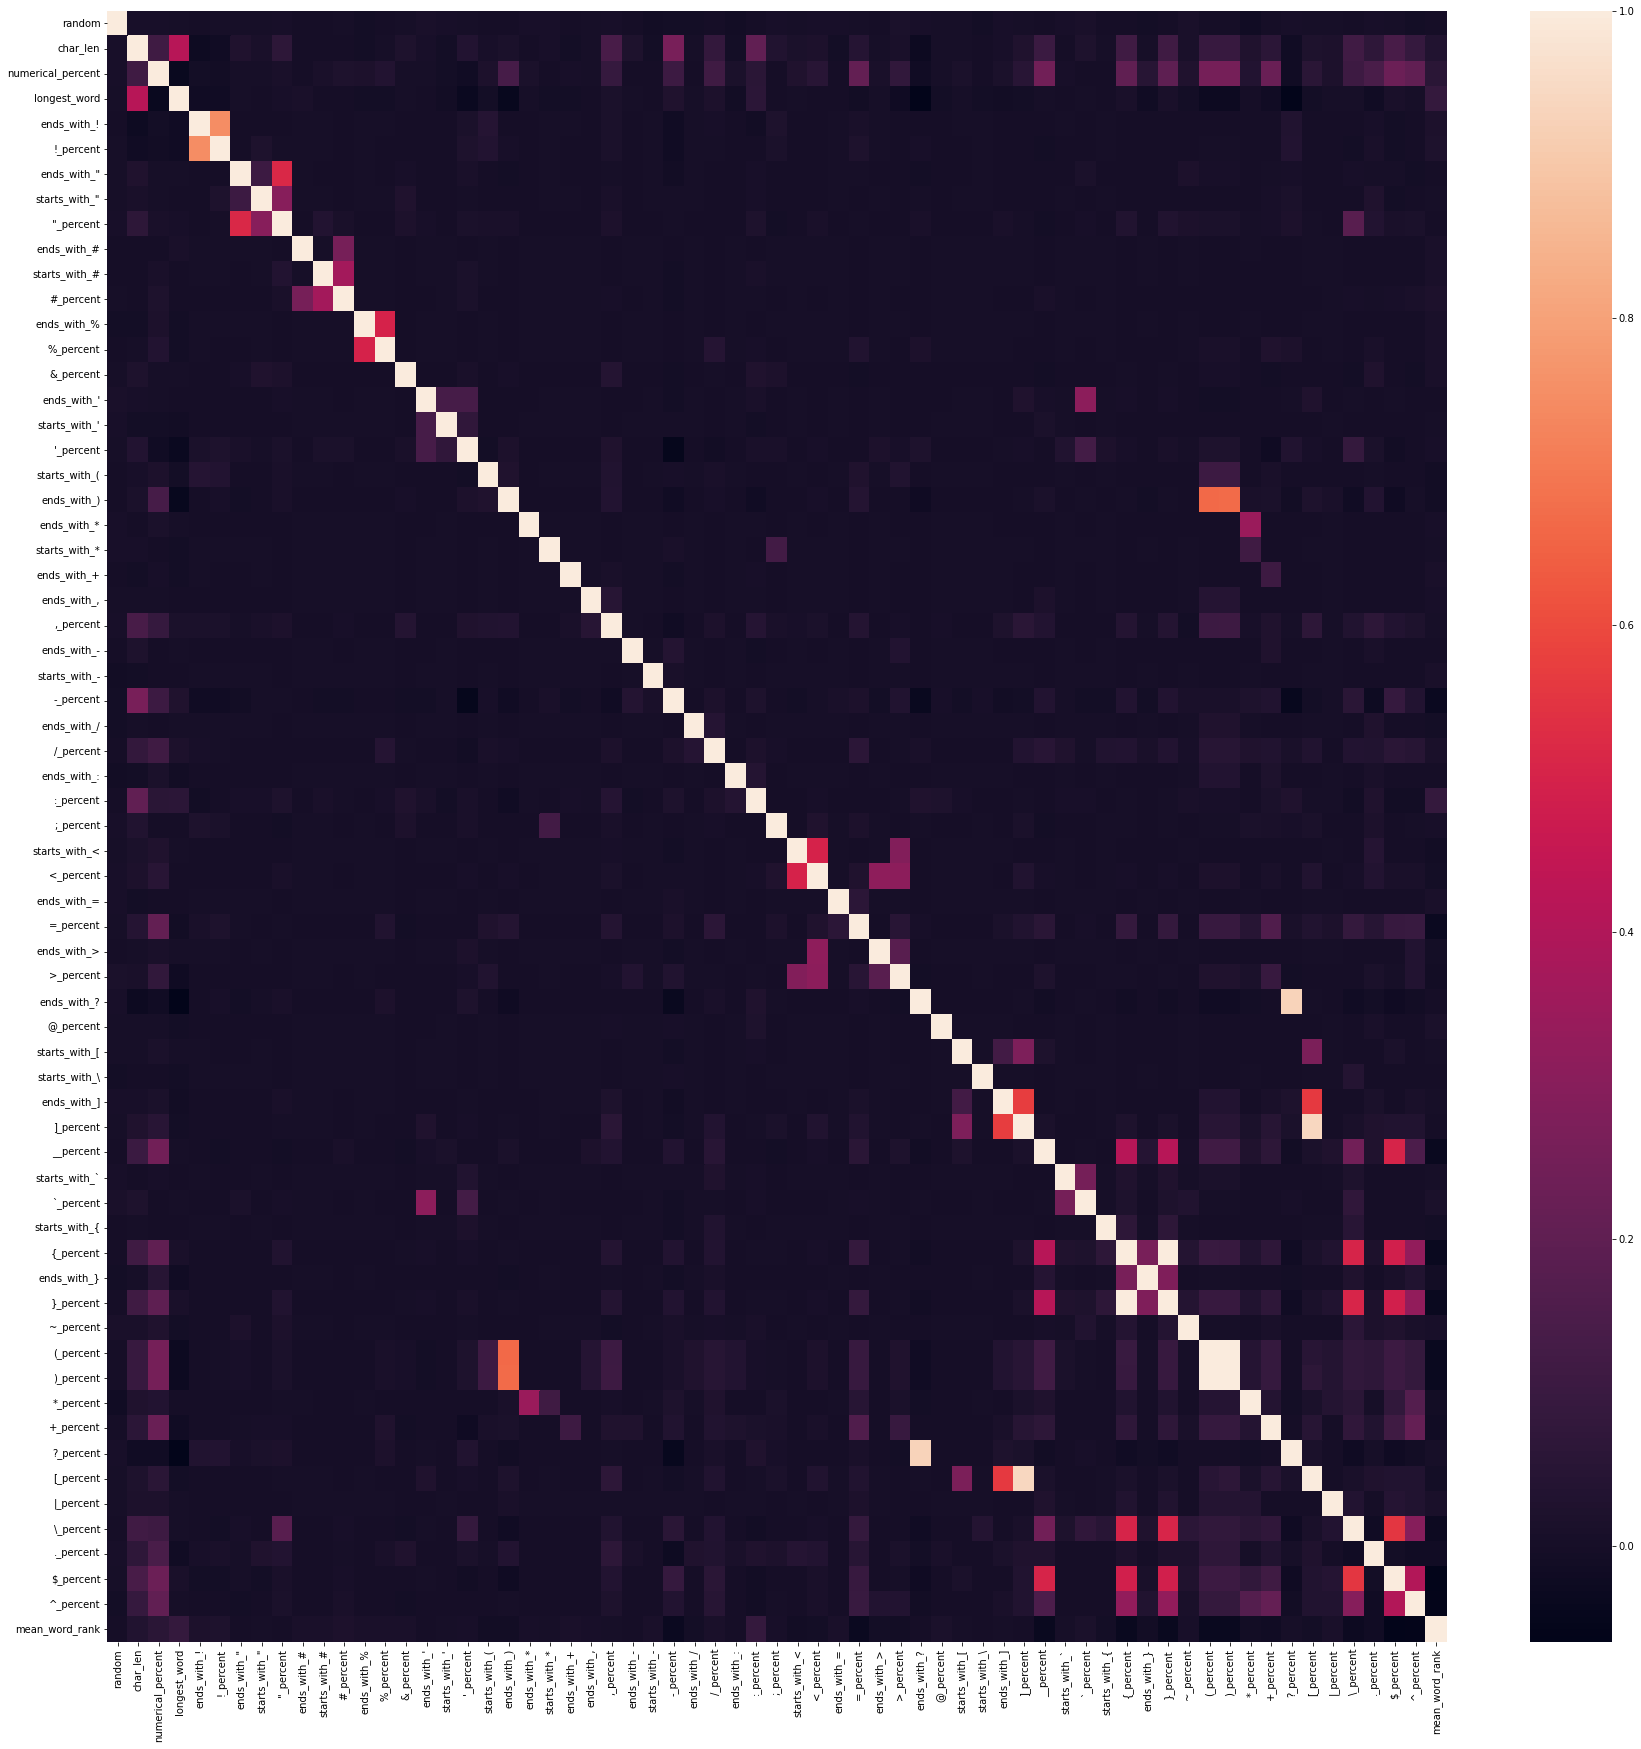

In [26]:
plt.figure(figsize = (30, 30))
sns.heatmap(train_data_title_source_df.corr(method='spearman'))

# Random Forest Hyperparameter Tuning

In [27]:
def tree_hyper_loop(train_df,
                    iterations=10,
                    random_state=None,
                    **sweep_args):
    """Randomized hyperparameter tuning for RandomForestClassifier.
    Pass in any array-like object for any of the standard RF hyperparameters
    args to randomly scan over the contained values.  Results judged by OOB
    score. Can optionally fix the random state of the RF.

    Example::
        # Scan over various choices of n_estimators.
        tree_hyper_loop(train_df,
                        val_df,
                        n_estimators=[2, 5, 10, 15])
    """
    results = []
    for num in range(iterations):
        print(f'Step {num + 1} of {iterations}...')
        # Default args for performance:
        performance_args = {'oob_score': True,
                     'n_jobs': -1,}
        # Randomly choose hyperparameters among those provided in sweep_args.
        rand_args = {}
        for key, val in sweep_args.items():
            if val is not None:
                rand_args[key] = np.random.choice([p for p in val])
        print(f'Sweep parameters:')
        for key, val in rand_args.items():
            print(f'\t\t{key}: {val}')

        rf_args = {**performance_args, **rand_args}
        if random_state is not None:
            rf_args['random_state'] = random_state
        rf = RandomForestClassifier(**rf_args)
        train_df_features, train_df_labels = train_df.drop(['source', 'title'], axis=1), train_df['source']
        rf.fit(train_df_features, train_df_labels)
        result = {'train_score': rf.score(train_df_features, train_df_labels),
                  'oob_score': rf.oob_score_,
                  'rf_args': rf_args}

        print(f'Scores:')
        for key, val in result.items():
            if key.split('_')[-1] == 'score':
                print(f'\t\t{key}: {val}')
        print('\n' + 50 * '-')


        results.append(result)

        
    results.sort(key=lambda x: x['oob_score'], reverse=True)
    return results        

Run some random trials using a subset of the data. Choose somewhat generous numbers for `min_samples_leaf` to help with generalziation. (Also, empirically, a low $\mathcal{O}(1)$ `min_samples_leaf` seems to lead to results where the `random` column has a non-trivial permutation-based importance measure, which I took as evidence for overfitting).

*Interesting side note:* if no pruning is performed (i.e. `min_samples_leaf=1`, `max_depth=None`, and similar) one should *expect* to acheive a *training* accuracy of 1 in a binary RF problem. This is because every training example will appear in $\approx 1/ e = 63\%$ of all training trees and so the majority rule vote on any given training example will lead to correct classification;[see here](https://towardsdatascience.com/one-common-misconception-about-random-forest-and-overfitting-47cae2e2c23b)  Found this out after achieving 'train_score=1' for some hyperparameter choices.

In [28]:
# The sklearn warning about feature names is due to the presence of column
# labels on the training data.

rf_hyper_trials = tree_hyper_loop(train_data_title_source_df.sample(frac=.2, random_state=RANDOM_STATE),
                                  n_estimators=np.random.randint(100, 500, 100),
                                  min_samples_leaf=np.random.randint(25, 100, 100),
                                  max_features=['sqrt', 'log2'],
                                  random_state=RANDOM_STATE,
                                  iterations=20)

Step 1 of 20...
Sweep parameters:
		n_estimators: 124
		min_samples_leaf: 26
		max_features: sqrt


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Scores:
		train_score: 0.703187250996016
		oob_score: 0.6896698918611269

--------------------------------------------------
Step 2 of 20...
Sweep parameters:
		n_estimators: 314
		min_samples_leaf: 69
		max_features: sqrt


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Scores:
		train_score: 0.6982071713147411
		oob_score: 0.6891007398975526

--------------------------------------------------
Step 3 of 20...
Sweep parameters:
		n_estimators: 434
		min_samples_leaf: 64
		max_features: log2


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Scores:
		train_score: 0.6990608992601024
		oob_score: 0.688673875924872

--------------------------------------------------
Step 4 of 20...
Sweep parameters:
		n_estimators: 248
		min_samples_leaf: 76
		max_features: log2


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Scores:
		train_score: 0.6992031872509961
		oob_score: 0.6895276038702334

--------------------------------------------------
Step 5 of 20...
Sweep parameters:
		n_estimators: 389
		min_samples_leaf: 48
		max_features: sqrt


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Scores:
		train_score: 0.6976380193511668
		oob_score: 0.6908081957882755

--------------------------------------------------
Step 6 of 20...
Sweep parameters:
		n_estimators: 250
		min_samples_leaf: 38
		max_features: sqrt


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Scores:
		train_score: 0.7016220830961867
		oob_score: 0.6920887877063175

--------------------------------------------------
Step 7 of 20...
Sweep parameters:
		n_estimators: 411
		min_samples_leaf: 29
		max_features: sqrt


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Scores:
		train_score: 0.7043255549231645
		oob_score: 0.6910927717700626

--------------------------------------------------
Step 8 of 20...
Sweep parameters:
		n_estimators: 103
		min_samples_leaf: 77
		max_features: log2


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Scores:
		train_score: 0.6839783722253842
		oob_score: 0.6754410927717701

--------------------------------------------------
Step 9 of 20...
Sweep parameters:
		n_estimators: 297
		min_samples_leaf: 28
		max_features: log2


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Scores:
		train_score: 0.701195219123506
		oob_score: 0.6912350597609562

--------------------------------------------------
Step 10 of 20...
Sweep parameters:
		n_estimators: 331
		min_samples_leaf: 35
		max_features: sqrt


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Scores:
		train_score: 0.701195219123506
		oob_score: 0.691946499715424

--------------------------------------------------
Step 11 of 20...
Sweep parameters:
		n_estimators: 131
		min_samples_leaf: 26
		max_features: sqrt


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Scores:
		train_score: 0.7044678429140581
		oob_score: 0.690950483779169

--------------------------------------------------
Step 12 of 20...
Sweep parameters:
		n_estimators: 140
		min_samples_leaf: 47
		max_features: sqrt


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Scores:
		train_score: 0.7003414911781446
		oob_score: 0.6881047239612976

--------------------------------------------------
Step 13 of 20...
Sweep parameters:
		n_estimators: 175
		min_samples_leaf: 28
		max_features: sqrt


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Scores:
		train_score: 0.7058907228229937
		oob_score: 0.6912350597609562

--------------------------------------------------
Step 14 of 20...
Sweep parameters:
		n_estimators: 175
		min_samples_leaf: 79
		max_features: sqrt


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Scores:
		train_score: 0.6940808195788275
		oob_score: 0.6851166761525327

--------------------------------------------------
Step 15 of 20...
Sweep parameters:
		n_estimators: 317
		min_samples_leaf: 70
		max_features: sqrt


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Scores:
		train_score: 0.6969265793966989
		oob_score: 0.6892430278884463

--------------------------------------------------
Step 16 of 20...
Sweep parameters:
		n_estimators: 389
		min_samples_leaf: 80
		max_features: sqrt


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Scores:
		train_score: 0.6957882754695504
		oob_score: 0.6878201479795105

--------------------------------------------------
Step 17 of 20...
Sweep parameters:
		n_estimators: 413
		min_samples_leaf: 94
		max_features: sqrt


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Scores:
		train_score: 0.691946499715424
		oob_score: 0.6871087080250426

--------------------------------------------------
Step 18 of 20...
Sweep parameters:
		n_estimators: 250
		min_samples_leaf: 44
		max_features: log2


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Scores:
		train_score: 0.6992031872509961
		oob_score: 0.690950483779169

--------------------------------------------------
Step 19 of 20...
Sweep parameters:
		n_estimators: 139
		min_samples_leaf: 79
		max_features: log2


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Scores:
		train_score: 0.6910927717700626
		oob_score: 0.6842629482071713

--------------------------------------------------
Step 20 of 20...
Sweep parameters:
		n_estimators: 319
		min_samples_leaf: 58
		max_features: log2


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Scores:
		train_score: 0.6993454752418896
		oob_score: 0.6893853158793398

--------------------------------------------------


Inspect the best-performing hyperparameter combinations.

In [29]:
rf_hyper_trials[:3]

[{'oob_score': 0.6920887877063175,
  'rf_args': {'max_features': 'sqrt',
   'min_samples_leaf': 38,
   'n_estimators': 250,
   'n_jobs': -1,
   'oob_score': True,
   'random_state': 42},
  'train_score': 0.7016220830961867},
 {'oob_score': 0.691946499715424,
  'rf_args': {'max_features': 'sqrt',
   'min_samples_leaf': 35,
   'n_estimators': 331,
   'n_jobs': -1,
   'oob_score': True,
   'random_state': 42},
  'train_score': 0.701195219123506},
 {'oob_score': 0.6912350597609562,
  'rf_args': {'max_features': 'log2',
   'min_samples_leaf': 28,
   'n_estimators': 297,
   'n_jobs': -1,
   'oob_score': True,
   'random_state': 42},
  'train_score': 0.701195219123506}]

In [30]:
rf_args_best = rf_hyper_trials[0]['rf_args']
rf_args_best

{'max_features': 'sqrt',
 'min_samples_leaf': 38,
 'n_estimators': 250,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 42}

# Fine-Tune and Inspect Features

Use the best-performing hyperparameters to re-train on additional data using only the features with significant importance.

In [31]:
from sklearn.inspection import permutation_importance

Create a small training function which allows us to train only on a subset of columns and performs both gini-impurity-based and permutation-based feature-importance computations; [see here.](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.htmlhttps://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

In [32]:
def train_rf(train_df,
             val_df,
             rf_args,
             random_state=None,
             columns=None):
    """Simple training loop for a random forest. Returns a tuple of the model,
    a dict of its various scores, and ordered Series of feature importances both
    by Gini impurity decrease and through permutation-based importance.
    """
    if random_state is not None:
        rf_args['random_state'] = random_state
    rf = RandomForestClassifier(**rf_args)
    if columns is None:
        train_df_features, train_df_labels = train_df.drop(['source', 'title'], axis=1), train_df['source']
        val_df_features, val_df_labels = val_df.drop(['source', 'title'], axis=1), val_df['source']
    else:
        train_df_features, train_df_labels = train_df[columns], train_df['source']
        val_df_features, val_df_labels = val_df[columns], val_df['source']
    rf.fit(train_df_features, train_df_labels)
    scores = {'val_score': rf.score(val_df_features, val_df_labels),
              'train_score': rf.score(train_df_features, train_df_labels),
              'oob_score': rf.oob_score_
                         }
    # Gini importances.
    gini_import_series = pd.Series(rf.feature_importances_, index=train_df_features.columns)
    # Permutation importances.
    perm_import = permutation_importance(rf,
                                         val_df_features,
                                         val_df_labels,
                                         random_state=RANDOM_STATE,
                                         n_jobs=-1)
    perm_import_series = pd.Series(perm_import.importances_mean, index=val_df_features.columns)

    return rf, scores, gini_import_series, perm_import_series

We will iteratively pick out the features which seem to be driving the results the most. Retrain the model on the full training set, examine the scores, and plot the feature importances.

In [33]:
rf_0, rf_0_scores, rf_0_gini_import, rf_0_perm_import = train_rf(train_data_title_source_df,
                                                                 val_data_title_source_df,
                                                                 rf_args=rf_args_best,
                                                                 random_state=RANDOM_STATE,
                                                                 columns=None)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Inspect the scores:

In [34]:
rf_0_scores

{'oob_score': 0.6999886176085596,
 'train_score': 0.7048545899493484,
 'val_score': 0.703718459495352}

Compare the two feature importance measures.

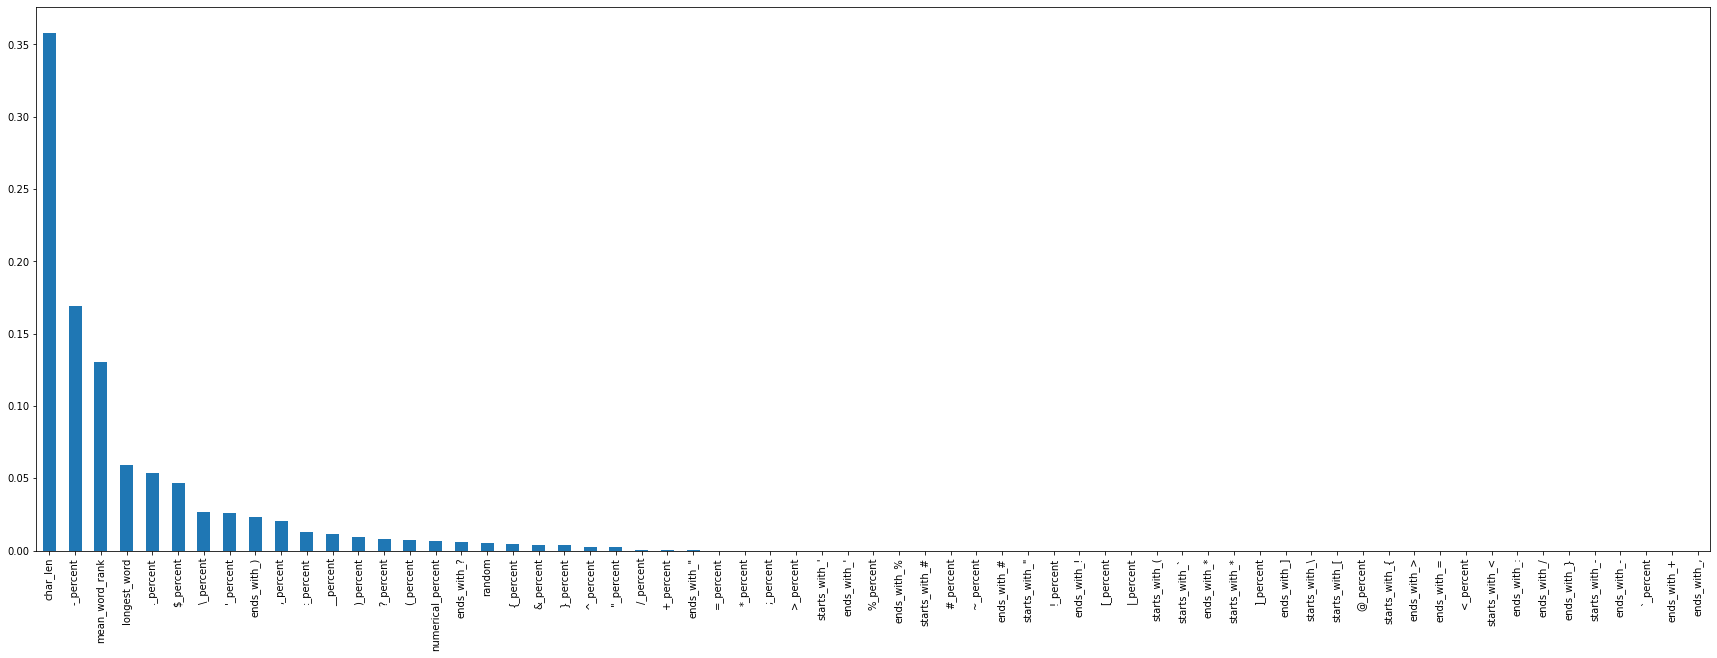

In [35]:
rf_0_gini_import_plt = rf_0_gini_import.sort_values(ascending=False).plot.bar(figsize=(30, 10))
plt.tick_params(axis='x', which='major', labelsize=10)
rf_0_gini_import_plt.figure.savefig(FOLDERNAME + '/figures/rf_0_gini_import_plt.png')

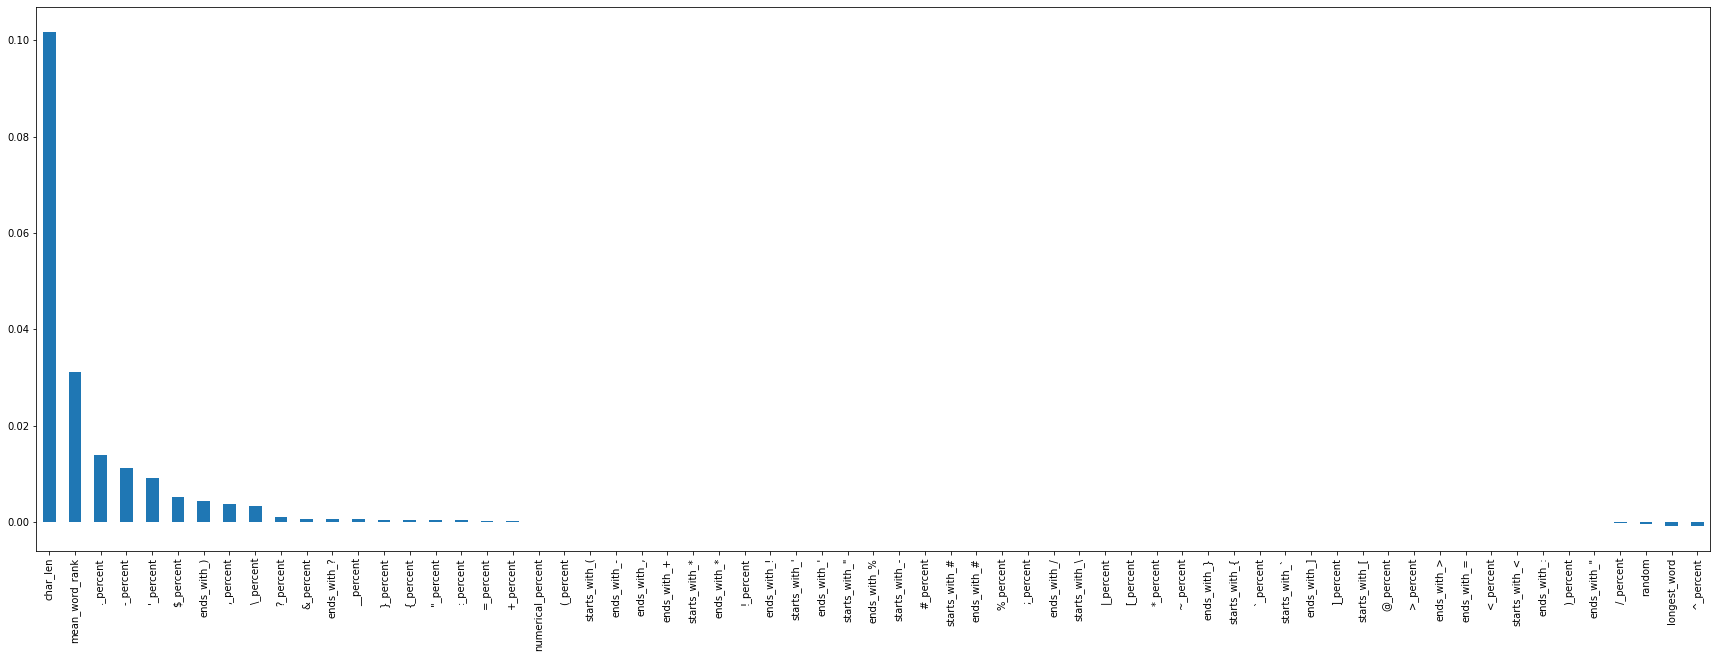

In [36]:
rf_0_perm_import_plt = rf_0_perm_import.sort_values(ascending=False).plot.bar(figsize=(30, 10))
plt.tick_params(axis='x', which='major', labelsize=10)
rf_0_perm_import_plt.figure.savefig(FOLDERNAME + '/figures/rf_0_perm_import_plt.png')

Pretty different looking! Compare how they have ranked the `random` column (which again consisted of random numbers as a sanity check):

In [37]:
for name, i in (('gini', rf_0_gini_import), ('perm', rf_0_perm_import)):
    print(f"{name} places 'random' in rank {i.rank(ascending=False)['random']} out of {len(i)}")

gini places 'random' in rank 18.0 out of 65
perm places 'random' in rank 63.0 out of 65


Not very reasonable for the gini measure! Precisely mirrors the example given [by Jeremy Howard and co-authors here](https://explained.ai/rf-importance/index.html), presumably for similar reasons, namely that purely by chance there may exist splits on the `random` column which are informative for the training set (roughly a form of the [look-elsewhere effect](https://en.wikipedia.org/wiki/Look-elsewhere_effect)). This has a greater effect on gini-based importance than permutation-based importance, apparently.

Let us re-train based on, say, the top `x` features, with `x` the number of features predicted to be more important than `random` in by gini importance.

In [38]:
gini_random_idx = (rf_0_gini_import > rf_0_gini_import['random']).sum()
top_gini_cols = rf_0_gini_import.sort_values(ascending=False)[:gini_random_idx].index
top_perm_cols = rf_0_perm_import.sort_values(ascending=False)[:gini_random_idx].index

The differences in the columns used:

In [39]:
set(top_gini_cols.values) - set(top_perm_cols.values)

{'(_percent', ')_percent', 'longest_word', 'numerical_percent'}

In [40]:
set(top_perm_cols.values) - set(top_gini_cols.values)

{'"_percent', '&_percent', '{_percent', '}_percent'}

In [41]:
# gini cols:
rf_1g, rf_1g_scores, rf_1g_gini_import, rf_1g_perm_import = train_rf(train_data_title_source_df,
                                                                     val_data_title_source_df,
                                                                     rf_args_best,
                                                                     random_state=RANDOM_STATE,
                                                                     columns=top_gini_cols)
# perm cols:
rf_1p, rf_1p_scores, rf_1p_gini_import, rf_1p_perm_import = train_rf(train_data_title_source_df,
                                                                     val_data_title_source_df,
                                                                     rf_args_best,
                                                                     random_state=RANDOM_STATE,
                                                                     columns=top_perm_cols)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Not a huge differnce in accuracy, ultimately.

In [42]:
pd.DataFrame({'rf_0': rf_0_scores,
                        'rf_1g': rf_1g_scores,
                        'rf_1p': rf_1p_scores
                        })

,rf_0,rf_1g,rf_1p
val_score,0.703718,0.709296,0.714608
train_score,0.704855,0.710375,0.706790
oob_score,0.699989,0.701554,0.701810


# Final Model

Let us move forward with the model which keeps only the top perm-importance based features.  The perm-based feature-importances:

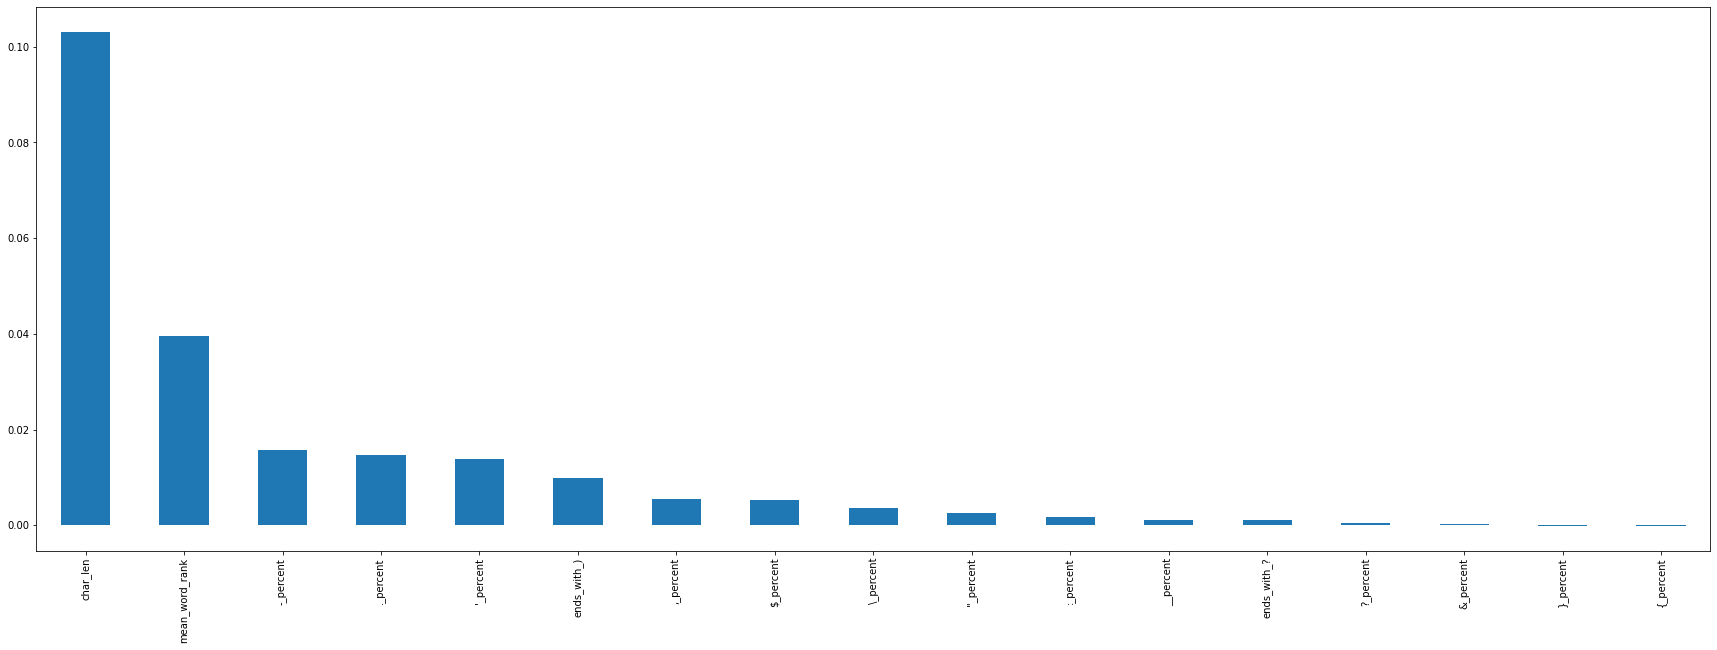

In [43]:
rf_1p_perm_import_plt = rf_1p_perm_import.sort_values(ascending=False).plot.bar(figsize=(30, 10))
plt.tick_params(axis='x', which='major', labelsize=10)
rf_1p_perm_import_plt.figure.savefig(FOLDERNAME + '/figures/rf_1p_perm_import.png')

Run the predictions on my own papers:

In [44]:
goon_papers_df = pd.read_feather(FOLDERNAME + '/data/goon_papers.feather')
goon_papers_df

,title,abstract,source
0,"quantum corrections to generic branes : dbi , ...",we study quantum corrections to hypersurfaces ...,arxiv
1,universal relation between corrections to entr...,perturbative corrections to general relativity...,arxiv
2,primordial non - gaussianity,our current understanding of the universe is e...,arxiv
3,"superluminality , black holes and eft",under the assumption that a uv theory does not...,arxiv
4,shapes of gravity : tensor non - gaussianity a...,if the graviton is the only high spin particle...,arxiv
5,the effective theory of shift - symmetric cosm...,a shift symmetry is a ubiquitous ingredient in...,arxiv
6,partially massless fields during inflation,the representation theory of de sitter space a...,arxiv
7,soft theorems for shift - symmetric cosmologies,we derive soft theorems for single - clock cos...,arxiv
8,heavy fields and gravity,we study the effects of heavy fields on 4d spa...,arxiv
9,aspects of galileon non - renormalization,we discuss non - renormalization theorems appl...,arxiv


In [45]:
goon_papers_df_engineered = feature_engineering_helper(goon_papers_df, trivial_features=trivial_features)

missing ), unterminated subpattern at position 0
Failed on character (
unbalanced parenthesis at position 0
Failed on character )
nothing to repeat at position 0
Failed on character *
nothing to repeat at position 0
Failed on character +
nothing to repeat at position 0
Failed on character ?
unterminated character set at position 0
Failed on character [
bad escape (end of pattern) at position 0
Failed on character \


In [46]:
goon_papers_df_engineered_predictions = rf_1p.predict(goon_papers_df_engineered[top_perm_cols])

Not great results!

In [ ]:
(goon_papers_df_engineered_predictions == 'arxiv').mean()

In [47]:
goon_papers_df['rf_pred'] = goon_papers_df_engineered_predictions
with pd.option_context('display.max_colwidth', None):
    display(goon_papers_df)

,title,abstract,source,rf_pred
0,"quantum corrections to generic branes : dbi , nlsm , and more","we study quantum corrections to hypersurfaces of dimension d + 1 > 2 embedded in generic higher - dimensional spacetimes . manifest covariance is maintained throughout the analysis and our methods are valid for arbitrary co - dimension and arbitrary bulk metric . a variety of theories which are prominent in the modern amplitude literature arise as special limits : the scalar sector of dirac - born - infeld theories and their multi - field variants , as well as generic non - linear sigma models and extensions thereof . our explicit one - loop results unite the leading corrections of all such models under a single umbrella . in contrast to naive computations which generate effective actions that appear to violate the non - linear symmetries of their classical counterparts , our efficient methods maintain manifest covariance at all stages and make the symmetry properties of the quantum action clear . we provide an explicit comparison between our compact construction and other approaches and demonstrate the ultimate physical equivalence between the superficially different results .",arxiv,vixra
1,universal relation between corrections to entropy and extremality,"perturbative corrections to general relativity alter the expressions for both the entropy of black holes and their extremality bounds . we prove a universal relation between the leading corrections to these quantities . the derivation is purely thermodynamic and the result also applies beyond the realm of gravitational systems . in scenarios where the correction to the entropy is positive , our result proves that the perturbations decrease the mass of extremal black holes , when holding all other extensive variables fixed in the comparison . this implies that the extremality relations of a wide class of black holes display weak gravity conjecture - like behavior .",arxiv,arxiv
2,primordial non - gaussianity,"our current understanding of the universe is established through the pristine measurements of structure in the cosmic microwave background ( cmb ) and the distribution and shapes of galaxies tracing the large scale structure ( lss ) of the universe . one key ingredient that underlies cosmological observables is that the field that sources the observed structure is assumed to be initially gaussian with high precision . nevertheless , a minimal deviation from gaussianityis perhaps the most robust theoretical prediction of models that explain the observed universe ; itis necessarily present even in the simplest scenarios . in addition , most inflationary models produce far higher levels of non - gaussianity . since non - gaussianity directly probes the dynamics in the early universe , a detection would present a monumental discovery in cosmology , providing clues about physics at energy scales as high as the gut scale .",arxiv,vixra
3,"superluminality , black holes and eft","under the assumption that a uv theory does not display superluminal behavior , we ask what constraints on superluminality are satisfied in the effective field theory ( eft ) . we study two examples of effective theories : quantum electrodynamics ( qed ) coupled to gravity after the electron is integrated out , and the flat - space galileon . the first is realized in nature , the second is more speculative , but they both exhibit apparent superluminality around non - trivial backgrounds . in the qed case , we attempt , and fail , to find backgrounds for which the superluminal signal advance can be made larger than the putative resolving power of the eft . in contrast , in the galileon case it is easy to find such backgrounds , indicating that if the uv completion of the galileon is ( sub ) luminal , quantum corrections must become important at distance scales of order the vainshtein radius of the background configuration , much larger than the naive eft strong coupling distance scale . such corrections wou

Write the model to our final models folder:

In [49]:
import joblib
joblib.dump(rf_1g, FOLDERNAME + '/final_models/' + PROJECT + '.joblib')

['/content/drive/My Drive/ML/arxiv_vixra/final_models/balanced_title_rf.joblib']